In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from Bitcoin_MonteCarlo import Financial_Timeseries


data = Financial_Timeseries('BTC-USD', period='max')


C:\Users\G_MAN\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\G_MAN\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


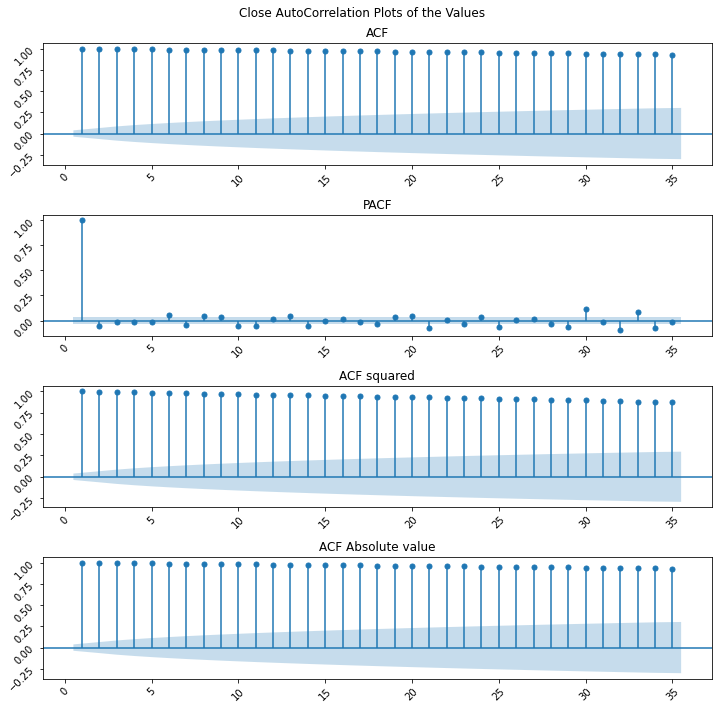

In [2]:
data.plot_ACF_PACF('Close')

In [3]:
import pmdarima as arima
from arch import arch_model
log_returns = np.log(1+data.timeseries['Close'].pct_change()).dropna()
arima_model_fitted = arima.auto_arima(log_returns)

arima_residuals = arima_model_fitted.arima_res_.resid

model = arch_model(arima_residuals, vol='GARCH', p=1, q=1, rescale=True, mean='Zero')
fitted_model = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12342.579712089017
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1640.1536526068467
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1440.278645840835
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1121.0897454351398
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1103.556693855307
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1099.4132444960899
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1099.1590537301904
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1099.1590333806892
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1099.1590333800852
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1099.1590333806892
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


In [4]:
print(fitted_model.scale)

10.0


In [5]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1099.16
Distribution:                  Normal   AIC:                           2204.32
Method:            Maximum Likelihood   BIC:                           2222.05
                                        No. Observations:                 2725
Date:                Sun, Mar 06 2022   Df Residuals:                     2725
Time:                        21:18:12   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.8922e-03  2.512e-03      2.743  6.084e-03 [1.968e-03,1.182e-02]
alpha[1]       0.1262  3.561e-02      3.545  3.924e-04   [5.644e-02,  0.196]
beta[1]        0.8426  2.824e-02     29.841 1.164e-195     [  0.787,  0.898]
============================================================================

Covariance estimator: robust
"""

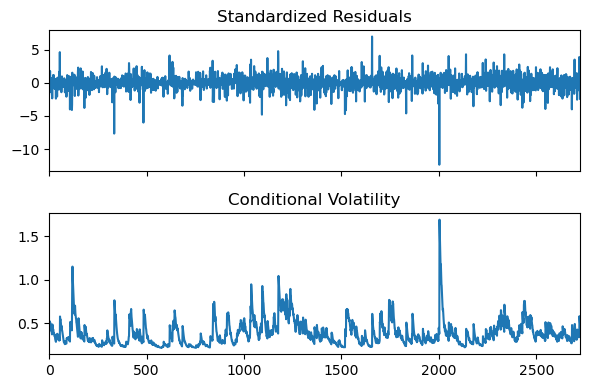

In [6]:
results = fitted_model.plot()
results.tight_layout()
results.set_dpi(100)